In [3]:
import sys
sys.path.append("../../src")
#sys.path.append("/home/rosa/Desktop/Master/S2/Special_Topics/Bram_code/src")
import os
import numpy as np
import pickle
from example_duffing import simulate_duffing, generate_duffing_data, get_duffing_data
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate
#import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

## Generate the duffing data and plot it on 2D

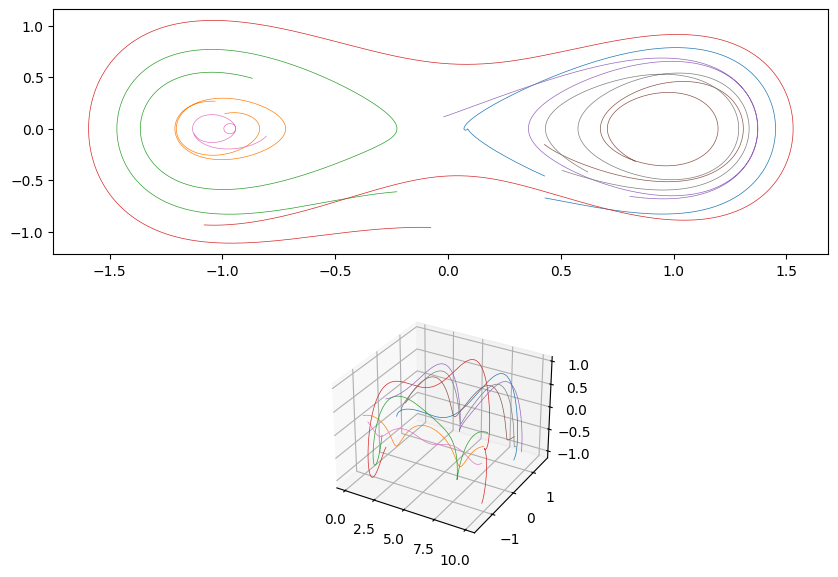

In [4]:
sys_params = {'gamma': 0.1, 'alpha':-1., 'beta':1., 'delta': 0.01, 'omega': 1.}
# Time points
dt = 0.001 # 100000/100
t = np.arange(0, 10, 0.01)

# Initial condition
z0s = np.random.rand(8, 2) * 2 - 1
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(211)
# Create a 3D plot
ax_3d = fig.add_subplot(212, projection='3d')


for z0 in z0s:
    # Simulate the Duffing dynamics
    z, _, _ = simulate_duffing(z0, t, **sys_params)

    # Extract the trajectory (x and y components)
    x = z[:, 0]
    y = z[:, 1]

    # Plot the trajectory
    ax.plot(x, y, lw=0.5)
    # plt.axis('off')  # Remove axes for a presentational plot
    ax_3d.plot(t, x, y, lw=0.5)

plt.show()

In [5]:
data_path = os.getcwd() + '/'
print(data_path)

save_name = 'duffing_2024_06_05_10_33_11_843174'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name


/Users/saschimi/Documents/github/SindyAutoencoders/examples/duffing/


In [6]:

autoencoder_network = full_network(params)


In [7]:

learning_rate = tf.compat.v1.placeholder(tf.float32, shape = [], name='learning_rate') # deprecated in TF 2.0
saver = tf.compat.v1.train.Saver(var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES))
tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [59]:
t = np.arange(0, 10, 0.01)
# Initial condition
z0 = np.random.rand(1, 2) * 2 - 1

test_data = generate_duffing_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/1,1/1]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

points in high-dimensional dataset:  8


In [60]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /Users/saschimi/Documents/github/SindyAutoencoders/examples/duffing/duffing_2024_06_05_10_33_11_843174


In [61]:
# a1 = 1
# a2 = test_data['sindy_coefficients'][2,0]/test_set_results['sindy_coefficients'][2,0]
# a3 = np.sqrt(-test_set_results['sindy_coefficients'][5,2]/test_set_results['sindy_coefficients'][6,1]*a2**2)
# b3 = -test_set_results['sindy_coefficients'][0,2]/test_set_results['sindy_coefficients'][3,2]

# sindy_coefficients_transformed = np.zeros(test_set_results['sindy_coefficients'].shape)
# sindy_coefficients_transformed[1,0] = test_set_results['sindy_coefficients'][1,0]
# sindy_coefficients_transformed[2,0] = test_set_results['sindy_coefficients'][2,0]*a2/a1
# sindy_coefficients_transformed[1,1] = test_set_results['sindy_coefficients'][6,1]*a1/a2*b3
# sindy_coefficients_transformed[2,1] = test_set_results['sindy_coefficients'][2,1]
# sindy_coefficients_transformed[6,1] = test_set_results['sindy_coefficients'][6,1]*a1*a3/a2
# sindy_coefficients_transformed[3,2] = test_set_results['sindy_coefficients'][3,2]
# sindy_coefficients_transformed[5,2] = test_set_results['sindy_coefficients'][5,2]*a1*a2/a3

# z0_transformed = np.array([test_set_results['z'][0,0]/a1,
#                            test_set_results['z'][0,1]/a2,
#                            (test_set_results['z'][0,2] - b3)/a3])

In [62]:
# duffing_sim = sindy_simulate(test_data['z'][0], t,
#                             params['poly_order'], params['include_sine'], **sys_params)
# Evolve the new initial condition in time with the SINDy model
# t = np.arange(0, 100, 0.01)
duffing_sim, _, _ = simulate_duffing(test_set_results['z'][0], t, **sys_params)

z_sim = sindy_simulate(test_set_results['z'][0], t, params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])
# z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
                                #    params['poly_order'], params['include_sine'])

/Users/saschimi/Documents/github/SindyAutoencoders/examples/duffing/../../src/sindy_utils.py:135: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  x = odeint(f, x0, t)


In [63]:
print(duffing_sim.shape, z_sim.shape)

(1000, 2) (1000, 2)


In [65]:
test_set_results['z'] = test_set_results['z'].reshape((-1,params['latent_dim']))
test_set_results['z'].shape

(1000, 2)

(-1.9093503512379666,
 1.9677933205334612,
 -1.8274701186019857,
 1.703623934327856)

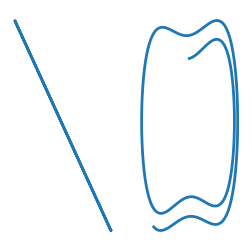

In [66]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(121)
ax1.plot(z_sim[:,0], z_sim[:,1], linewidth=2)
plt.axis('off')

ax3 = fig1.add_subplot(122)
ax3.plot(duffing_sim[:,0], duffing_sim[:,1], linewidth=2)
plt.xticks([])
plt.axis('off')

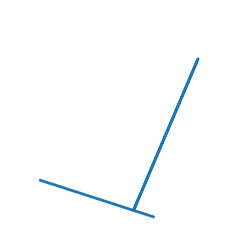

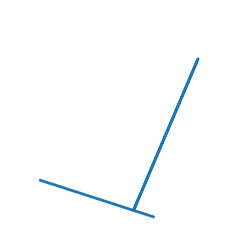

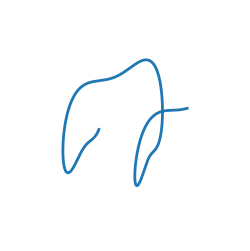

In [67]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(t, z_sim[:,0], z_sim[:,1], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(t, z_sim[:,0], z_sim[:,1], linewidth=2)
plt.axis('off')
ax2.view_init(azim=120)

fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(t, duffing_sim[:,0], duffing_sim[:,1], linewidth=2)
plt.xticks([])
plt.axis('off')
ax3.view_init(azim=120)

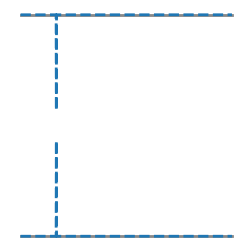

In [68]:
plt.figure(figsize=(3,3))
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.plot(t, test_set_results['z'][:,i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

KeyError: 'sindy_coefficients'

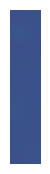

In [69]:
Xi_plot = (params['coefficient_mask']*test_set_results['sindy_coefficients'])
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

# Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
# Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
# plt.figure(figsize=(1,2))
# plt.imshow(Xi_transformed_plot, interpolation='none')
# plt.xticks([])
# plt.yticks([])
# plt.axis('off')
# plt.clim([-10,30])

Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

## Test set analysis - in distribution

In [12]:
test_data = get_duffing_data(100, noise_strength=1e-6)

In [13]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /Users/saschimi/Documents/github/SindyAutoencoders/examples/lorenz/model1


In [14]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.000027
Decoder relative SINDy error: 0.000125
SINDy reltive error, z: 0.000524


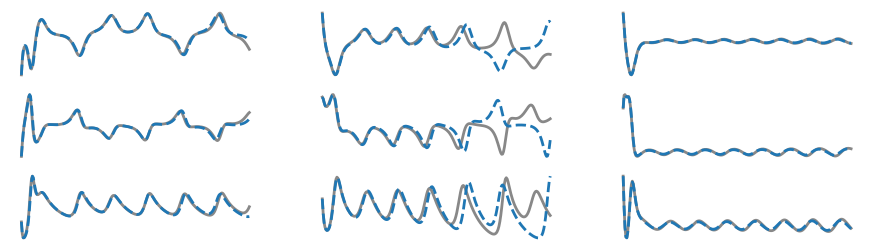

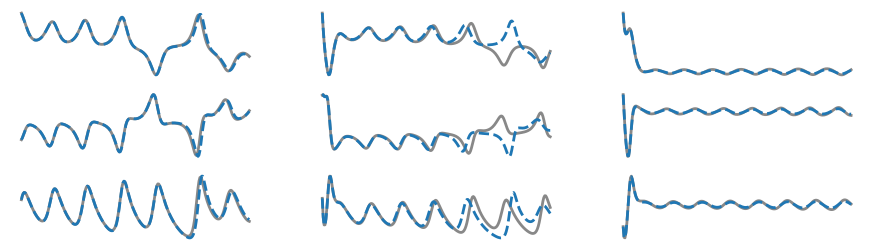

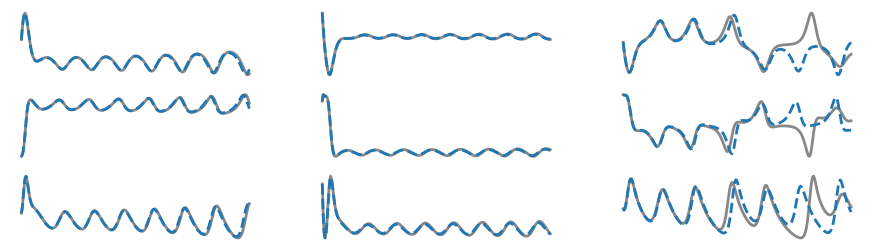

In [15]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)

    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])

    col_idx = ic % 3

    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

## Test set analysis - out of distribution

In [16]:
inDist_ic_widths = np.array([36,48,41])
outDist_extra_width = np.array([18,24,20])
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:

    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1

noise_strength = 1e-6

# training test_data
test_data = generate_duffing_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/1,1/1,1/1]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

In [17]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /Users/saschimi/Documents/github/SindyAutoencoders/examples/lorenz/model1


In [18]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.013185
Decoder relative SINDy error: 0.093113
SINDy reltive error, z: 0.074021


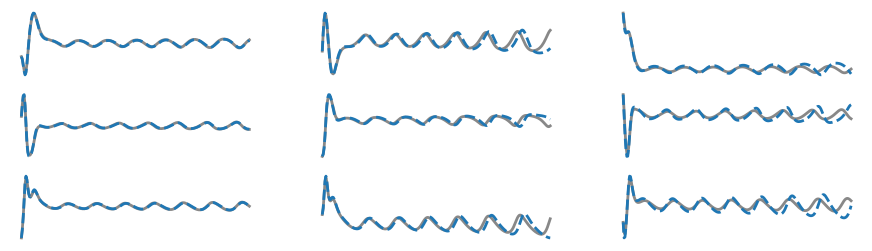

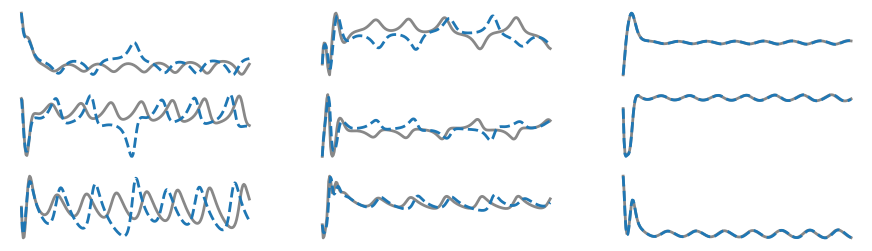

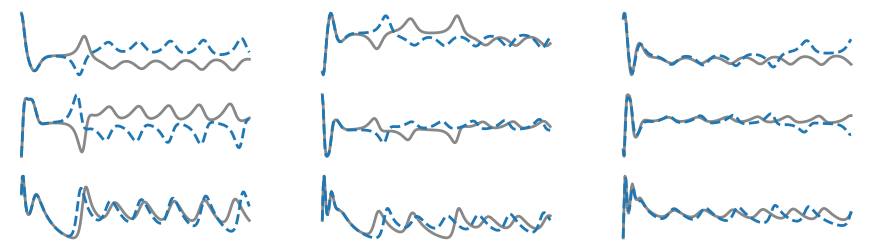

In [19]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)

    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])

    col_idx = ic % 3

    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')